# Kona 2022 run data walkthrough

#### Introduction
[Entalpi](https://www.entalpi.com/), a new methodology for endurance training incorperating advanced sports technology in a web application, has posted data from the running section of the 2022 Kona Ironman for Gustav Iden and Kristian Blummenfelt. They opened up this dataset for curious sports data enthusiasts (aka me!) to investigate and I jumped at the opportunity.

While we are fortunate to know roughly [what happened during this race](https://youtu.be/xA23ecuhB5w?t=3890) – we don't really know how [Gustav Iden pulled away from Kristian Blummenfelt](https://www.tri247.com/triathlon-news/elite/ironman-kona-world-championship-2022-results-men) late in the race. Iden ended up winning the race and finished 2:59 in front of Blummenfelt, but it is unclear if Iden accomplished this feat by increasing his speed, if Blummenfelt decreased his speed, or if there was a combination of both. What also could be useful to understand about the performance in the run is how this time gap varied over time as the athletes were pushing towards the finish line. Ie. How quickly did the time gap open up? Was it a constant, gradual difference in pace or more of a rapid acceleration and holding on to a time gap?

#### Time Gap Analysis
Comparing athletic performance in timed events is often best done by presenting relative time gaps to the event winner over time as a first step. Classically this has been done using splits from known distances, but it possible – and much more insightful – to do as a continous measure. So long as you have access to an athlete's position, distance travelled and speed throughout the race, a continous time gap can be computed. Much of this notebook is dedicated to outlining steps to make this analysis possible given the provided datasets.

A brief analysis of the time gaps and then how time gaps were created is also presented following the discovery of three distinct segments of in race of these two athletes. Finally, a quick example of calculating average pace over different distances is shown. These aspects of analysis are only made possible by first obtaining an accurate distance measure for each athlete and that takes precidence in this notebook. 

By comparing over distance we can also compare how athletes performed against one another even when they aren't competing at the exact same time. In this example, it is was clear that the athletes were travelling at the same speed for much of the race because they started together – but imagine had they been seperated prior to the run, it would be very insightful to know where time was gained/lost without the obvious visual evidence of an athlete running away from another one. This is something I have come across many times in cycling time trials from my experience in professional cycling; the athletes all start at staggered times throughout the day so you really don't know when an athlete is travelling faster than another one unless you assess their time gaps over their distance. 

#### Next steps
- Find competing athletes data uploaded to Strava and add into time gap graph.

- Incorperating elevation changes into this analysis and creating a grade adjusted pace could be helpful to understand the impacts of changing topography. 

- Also, while it's interesting to consider but not discussed here, Kristian Blummenfelt's core and skin temperature throughout the race was provided. The analysis of that data didn't really fit into what I was trying to showcase but I may expand on that in the future and link that data to the performance as well.

In [1]:
# import packages

# for data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# for plotting
from matplotlib import pyplot as plt
from matplotlib import lines
from matplotlib import patches
from matplotlib import ticker
import seaborn as sns

# custom functions
import functions as krf

In [2]:
# import datasets

# define the filenames
iden_path = "gustav_iden_copyright_entalpi_as.csv"
blummenfelt_path = "kristian_blummenfelt_copyright_entalpi_as.csv"

# load data:
# I added some funcationality to normal pd.read_csv() - remove null datetimes and adds unix timestamp in seconds
iden_dat = krf.load_csv_data(iden_path)
blummenfelt_dat = krf.load_csv_data(blummenfelt_path)

# first step, get a look at the data:
print("Gustav data")
# - check first few rows of data for both
display(iden_dat.head())
# - describe the dataframe
display(iden_dat.describe())

# same for Kristian
print("\n\nKristian data")
display(blummenfelt_dat.head())
display(blummenfelt_dat.describe())


Gustav data


,datetime,latitude,longitude,speed,elevation,heartrate,cadence,stride_length,timestamp_unix
0,2022-10-08 21:30:07+00:00,19.641770,-155.996329,3.490,-9.2,159,85.0,NaN,1665264607
1,2022-10-08 21:30:08+00:00,19.641794,-155.996302,3.490,-9.0,159,85.0,NaN,1665264608
2,2022-10-08 21:30:09+00:00,19.641816,-155.996277,3.490,-8.8,160,37.0,NaN,1665264609
3,2022-10-08 21:30:10+00:00,19.641829,-155.996242,3.527,-8.4,159,58.0,NaN,1665264610
4,2022-10-08 21:30:11+00:00,19.641835,-155.996200,3.546,-8.2,158,74.0,NaN,1665264611


,latitude,longitude,speed,elevation,heartrate,cadence,stride_length,timestamp_unix
count,9342.000000,9342.000000,9342.000000,9342.000000,9342.000000,9340.000000,9329.000000,9.342000e+03
mean,19.671364,-156.013109,4.517809,8.030250,164.795012,86.554497,1.568304,1.665269e+09
std,0.038593,0.022464,0.385124,13.154264,6.341497,2.003083,0.120721,2.696947e+03
min,19.600355,-156.054862,0.765000,-13.000000,150.000000,37.000000,0.325000,1.665265e+09
25%,19.639706,-156.033213,4.339000,-5.350000,160.000000,85.000000,1.514000,1.665267e+09
50%,19.670705,-156.015230,4.544000,8.600000,164.000000,86.000000,1.588000,1.665269e+09
75%,19.714464,-155.992332,4.759000,18.200000,170.000000,88.000000,1.648000,1.665272e+09
max,19.725627,-155.974369,5.570000,39.200000,182.000000,94.000000,2.690000,1.665274e+09




Kristian data


,datetime,latitude,longitude,speed,elevation,heartrate,cadence,core_temperature,skin_temperature,stride_length,timestamp_unix
0,2022-10-08 21:27:05+00:00,19.639484,-155.997351,0.000,9.6,138.0,0.0,38.860001,NaN,NaN,1665264425
1,2022-10-08 21:27:06+00:00,19.639443,-155.997342,0.000,9.4,139.0,0.0,38.860001,34.200001,NaN,1665264426
2,2022-10-08 21:27:07+00:00,19.639391,-155.997383,0.000,9.4,138.0,0.0,38.860001,34.200001,NaN,1665264427
3,2022-10-08 21:27:08+00:00,19.639349,-155.997340,0.000,9.4,139.0,0.0,38.860001,34.200001,NaN,1665264428
4,2022-10-08 21:27:09+00:00,19.639317,-155.997337,1.148,9.2,139.0,0.0,38.860001,34.200001,NaN,1665264429


,latitude,longitude,speed,elevation,heartrate,cadence,core_temperature,skin_temperature,stride_length,timestamp_unix
count,12189.000000,12189.000000,12189.000000,12189.000000,12069.000000,12158.000000,12189.000000,12188.000000,9710.000000,1.218900e+04
mean,19.664904,-156.009778,3.481805,-2.472656,133.346922,69.312880,39.353010,32.947994,1.531832,1.665271e+09
std,0.036526,0.020859,1.790481,14.094909,24.233572,34.572004,0.777131,2.567366,0.158863,3.522883e+03
min,19.600347,-156.054836,0.000000,-26.600000,55.000000,0.000000,38.240002,25.000000,0.380000,1.665264e+09
25%,19.640023,-156.030832,3.826000,-15.400000,140.000000,84.000000,38.869999,31.950001,1.488000,1.665267e+09
50%,19.649761,-156.000562,4.320000,0.000000,144.000000,86.000000,39.000000,34.099998,1.552000,1.665271e+09
75%,19.702768,-155.995834,4.544000,8.200000,147.000000,87.000000,40.040001,34.700001,1.610000,1.665274e+09
max,19.725848,-155.974404,5.636000,34.600000,158.000000,128.000000,40.810001,35.450001,1.885000,1.665277e+09


### Few things to point out from this:

1) Gustav does not have any temperature data columns 
2) Kristian has ~3000 more rows of data; probably kept his device running after/before finishing
3) Stride length reads in NaN values for the first few rows; probably needs to be initialized by running for a certain amount of time to detect pattern
4) No distance data: will need this data to compare the two athlete's efforts

Particularly on the issue of comparing over distance – this is how I want to show their time gaps to one another as well as their speed, cadence and stride length profiles. It will allow for better comparisons to be made based on where they were in the race when specific things happened rather than displaying over time.

There are 3 methods that could be used to obtain distance travelled:
1) compute the distance from the GPS signal's proximity to a known map of the course (most preferred)
2) compute the distance from the cumulative sum of the distance travelled between GPS data points (should be OK for shorter duration events)
3) compute the distance cumulatively from the measured speed of an athlete (least preferred and depends on how speed is calculated)

For this course, I could not find an absolute course gpx file so the method of computing distance from the proximity to a course map is not immediately feasible. The next best solution in my opinion is to obtain a distance measure from method 2 as described above. For this, the two datasets will need to be inspected and prepared – I will explain my steps to produce this in subsequent code blocks.


#### Check for timestamp irregularities

I check for duplicates, discontinuities and gaps in the GPS recording using custom functions. In my experience, these are common occurances with the raw fit files produced from Garmin devices, although I assume some level of processing has gone into these datasets as it has already been converted to a csv file.

In [3]:
# for Gustav
iden_duplicates = krf.id_duplicates(iden_dat)
iden_discons = krf.id_discons(iden_dat)
iden_gps_gaps = krf.id_gps_gaps(iden_dat)

print("\n- No duplicates, discontinuities or gaps for Gustav's file\n\n")

# for kristian
blummenfelt_duplicates = krf.id_duplicates(blummenfelt_dat)
blummenfelt_discons = krf.id_discons(blummenfelt_dat)
blummenfelt_gps_gaps = krf.id_gps_gaps(blummenfelt_dat)

# print the resulting dataframes to inspect
display(blummenfelt_discons)
print(
    f"- Can see there is {len(blummenfelt_discons)} discontinuity in Kristian's dataset at index {blummenfelt_discons.index.values[0]} with {blummenfelt_discons.delta_seconds.values[0]} seconds between timestamps"
)
print("- It is late in the recording - probably after he finished the race because speed is 0 m/s")




- No duplicates, discontinuities or gaps for Gustav's file




,datetime,latitude,longitude,speed,elevation,heartrate,cadence,core_temperature,skin_temperature,stride_length,timestamp_unix,delta_seconds
12026,2022-10-09 00:50:27+00:00,19.640336,-155.996472,0.0,-26.0,86.0,0.0,38.919998,33.150002,NaN,1665276627,177.0


- Can see there is 1 discontinuity in Kristian's dataset at index 12026 with 177.0 seconds between timestamps
- It is late in the recording - probably after he finished the race because speed is 0 m/s


#### Visualize the location & route

This next step can head off early issues in GPS errors – looking for obvious changes in position that do not reflect the course. 

For this I will use geopandas to map the GPS signal and tilemapbase to create OpenStreetMap tiles as a basemap in matplotlib.

I will do this for both Gustav & Kristian and then also check the start and finish data to get a better idea of how the data will need to be cropped.

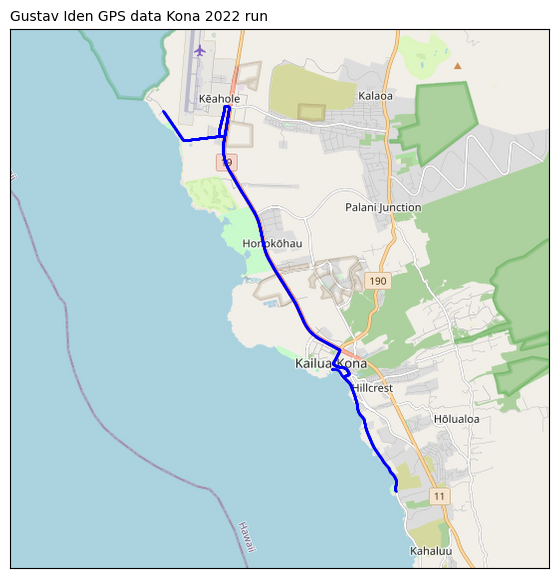

- This course was fairly straight forward: up and down the coast, with some overlapping 'out & back' segments.
- It also starts and finishes in same general location.

- Will probably need to zoom in on the start to get a good look as it crosses over itself a bunch

- No crazy outlier data


In [4]:
# create figure and axis for plot of Gustav's data
fig, ax = krf.plot_one_gps(df = iden_dat,
                          figsize = (7,7),
                          color = 'blue')
# set the title of the axis
ax.set_title('Gustav Iden GPS data Kona 2022 run',
            fontsize = 10,
            loc = 'left')
# show the plot
plt.show()

print(
    "- This course was fairly straight forward: up and down the coast, with some overlapping 'out & back' segments."
    "\n- It also starts and finishes in same general location."
)
print(
    "\n- Will probably need to zoom in on the start to get a good look as it crosses over itself a bunch"
    "\n\n- No crazy outlier data"
)

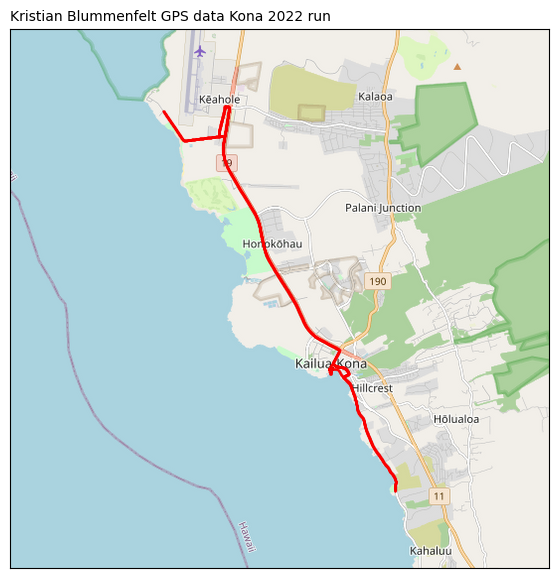

- Looks same in shape & content to Gustav's file, no massively erroneous data


In [5]:
# create figure and axis for plot of Kristian's data
fig, ax = krf.plot_one_gps(df = blummenfelt_dat,
                          figsize = (7,7),
                          color = 'red')
# set the title of the axis
ax.set_title('Kristian Blummenfelt GPS data Kona 2022 run',
            fontsize = 10,
            loc = 'left')
# show the plot
plt.show()

print(
    "- Looks same in shape & content to Gustav's file, no massively erroneous data"
)

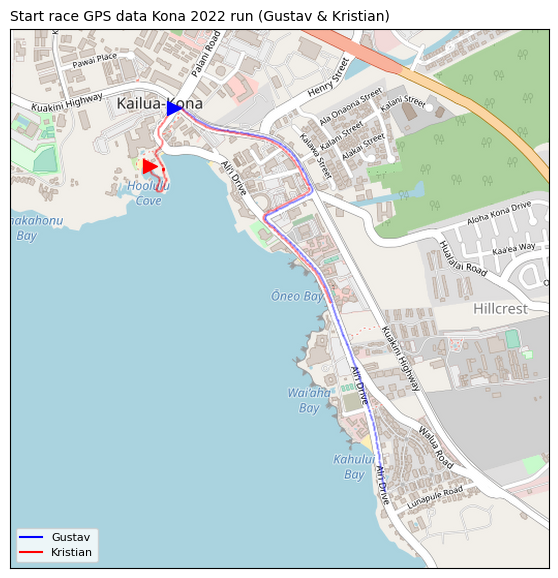


- We see that the two athlete's have different starting points of their runs (marked on plot)

- Gustav's data turns on later into the run than Kristian's – accounts for some difference in rows


In [6]:
# create figure and axis for plot at start of race
fig, ax = krf.plot_compare_gps(df1 = iden_dat.iloc[:500,:].copy(),
                               df2 = blummenfelt_dat.iloc[:500,:].copy(),
                               figsize = (7,7),
                               colors = ['blue', 'red'],
                               labels = ['Gustav', 'Kristian'],
                               start = True,
                               special_marker = ">")
# set the title of the axis
ax.set_title('Start race GPS data Kona 2022 run (Gustav & Kristian)',
            fontsize = 10,
            loc = 'left')
# show the plot
plt.show()

print(
    "\n- We see that the two athlete's have different starting points of their runs (marked on plot)"
    "\n\n- Gustav's data turns on later into the run than Kristian's – accounts for some difference in rows"
)

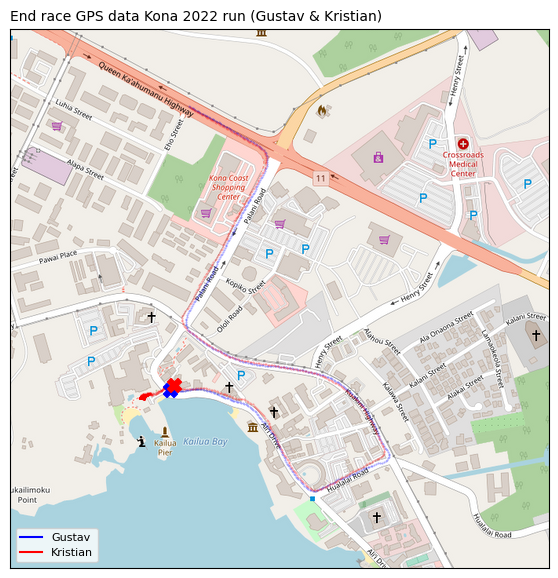


- We see that the two athlete's have similar ending points of their runs (marked on plot by 'x')

- Gustav's data turns off earlier after the run than Kristian's

- See Kristian's excess data (concentrated red dots) after finish line


In [7]:
# create figure and axis for plot at end of race
fig, ax = krf.plot_compare_gps(df1 = iden_dat.iloc[-500:,:].copy(),
                               df2 = blummenfelt_dat.iloc[-3000:,:].copy(),
                               figsize = (7,7),
                               colors = ['blue', 'red'],
                               labels = ['Gustav', 'Kristian'],
                               start = False,
                               special_marker = "X")
# set the title of the axis
ax.set_title('End race GPS data Kona 2022 run (Gustav & Kristian)',
            fontsize = 10,
            loc = 'left')
# show the plot
plt.show()

print(
    "\n- We see that the two athlete's have similar ending points of their runs (marked on plot by 'x')"
    "\n\n- Gustav's data turns off earlier after the run than Kristian's"
    "\n\n- See Kristian's excess data (concentrated red dots) after finish line"
)

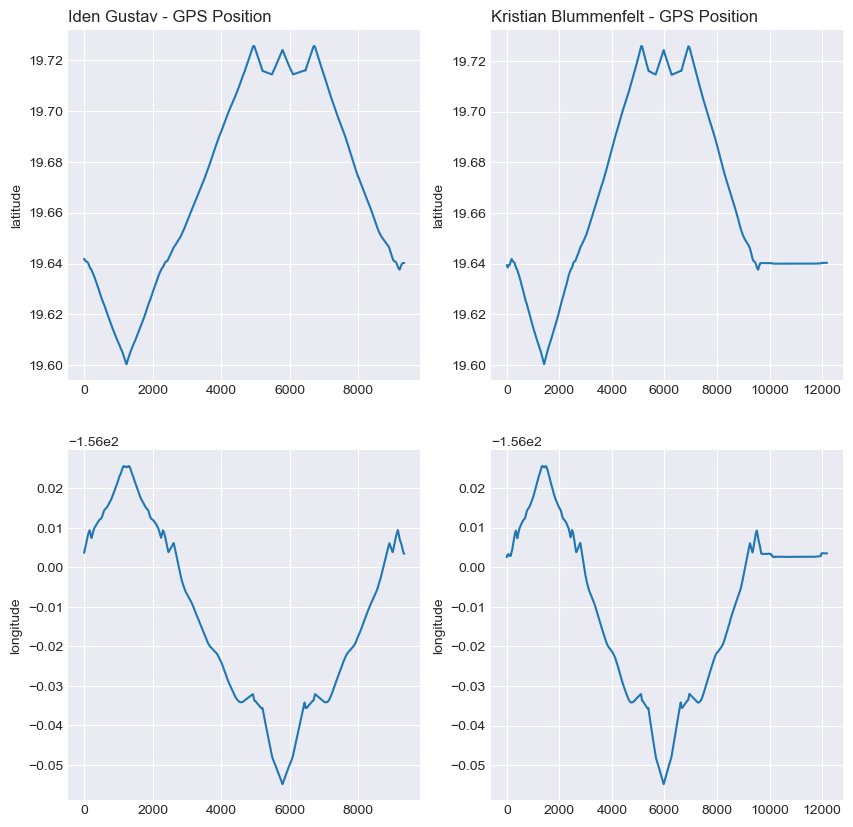



- Confimation of stationary end of race data from Kristian

- No obvious deviations in position

- Small changes in longitude – makes sense from course


In [8]:
# Now I want to check the latitude and longitude signals seperately to rule out major jumps in signal

# check the plot of the gps data over index
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, axes = plt.subplots(2,2, figsize = (10,10))
    axes[0,0].set_title('Iden Gustav - GPS Position',
                        loc = 'left')
    axes[0,1].set_title('Kristian Blummenfelt - GPS Position',
                        loc = 'left')
    sns.lineplot(data = iden_dat,
                 x = iden_dat.index.values,
                 y = 'latitude',
                 ax = axes[0,0])
    sns.lineplot(data = iden_dat,
                 x = iden_dat.index.values,
                 y = 'longitude',
                 ax = axes[1,0])
    sns.lineplot(data = blummenfelt_dat,
                 x = blummenfelt_dat.index.values,
                 y = 'latitude',
                 ax = axes[0,1])
    sns.lineplot(data = blummenfelt_dat,
                 x = blummenfelt_dat.index.values,
                 y = 'longitude',
                 ax = axes[1,1])
    
    plt.show()
    
print(
    "\n\n- Confimation of stationary end of race data from Kristian"
    "\n\n- No obvious deviations in position"
    "\n\n- Small changes in longitude – makes sense from course"
)

#### Compute Distance (1st try)

Moving on, and given no obvious visual errors in data, I will do a dry run on the raw GPS data to see what the calculated distance would look like. 

For this I will use custom functions that leverage geopy's geodesic distance calculation, which assumes an ellipse model of the Earth.

In [9]:
# lets try to compute the distance using the GPS 

# start with Gustav
# create a distance measure between each gps recording
iden_dat['distance_raw'] = krf.distance_from_gps(iden_dat)
# set initial distance travelled to the speed of the first data point (since in m/s)
iden_dat.loc[0,'distance_raw'] = iden_dat.speed[0].copy()
# cumulatively sum the distance over time
iden_dat['distance_travelled_raw'] = iden_dat.loc[:, 'distance_raw'].cumsum()

# same for Kristian
blummenfelt_dat['distance_raw'] = krf.distance_from_gps(blummenfelt_dat)
blummenfelt_dat.loc[0,'distance_raw'] = blummenfelt_dat.speed[0].copy()
blummenfelt_dat['distance_travelled_raw'] = blummenfelt_dat.loc[:,'distance_raw'].cumsum()

print(
    f"- Gustav's total distance travelled based on his raw GPS signal is {int(iden_dat.distance_travelled_raw.max())} m"
)
print(
    f"- Kristian's total distance travelled based on his raw GPS signal is {int(blummenfelt_dat.distance_travelled_raw.max())} m"
)

print(f"\n- So Kristian's unadjusted distance travelled is {int(blummenfelt_dat.distance_travelled_raw.max()) - int(iden_dat.distance_travelled_raw.max())} m more than Gustav and both are more than the full marathon length")

- Gustav's total distance travelled based on his raw GPS signal is 42228 m
- Kristian's total distance travelled based on his raw GPS signal is 43342 m

- So Kristian's unadjusted distance travelled is 1114 m more than Gustav and both are more than the full marathon length


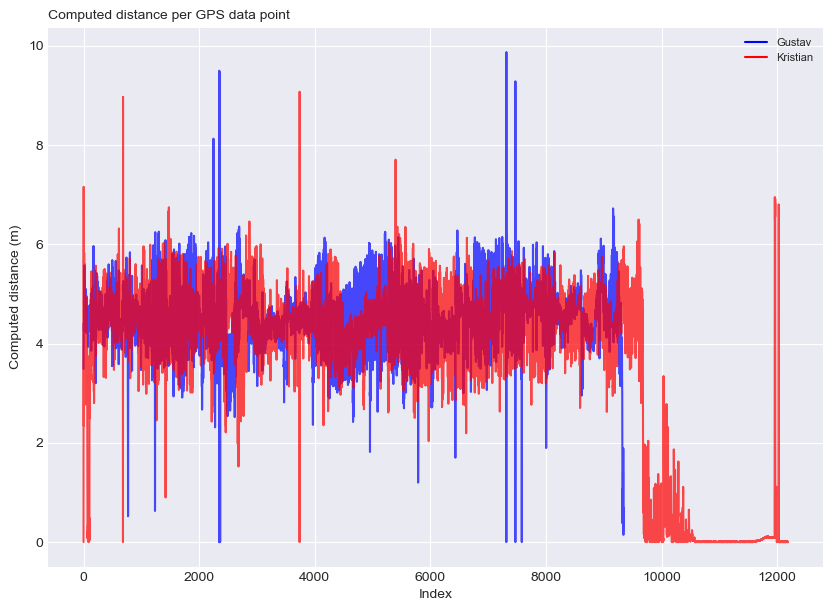



- Wow! Very noisy data...

- This is basically a representation of the speed (it is in m/s because the index is reporting at 1 Hz)

...so let's compare it to the speed



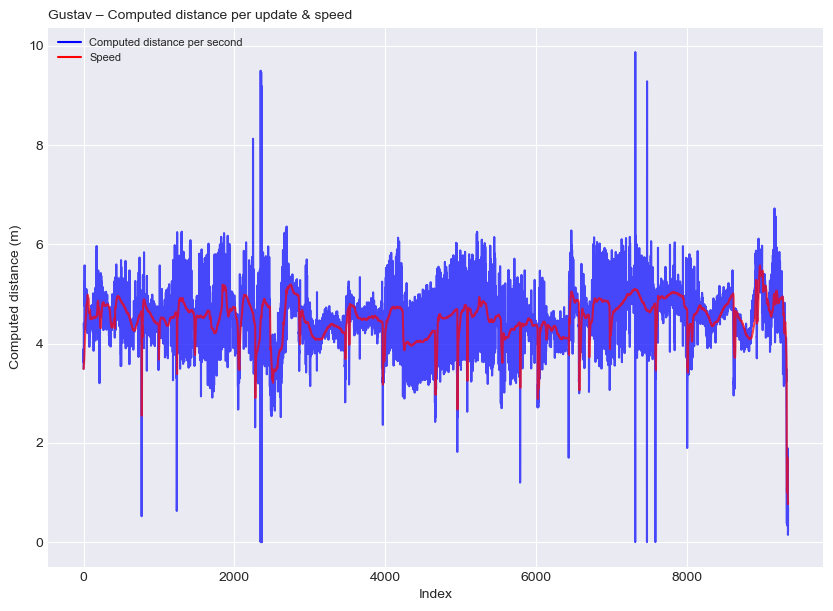

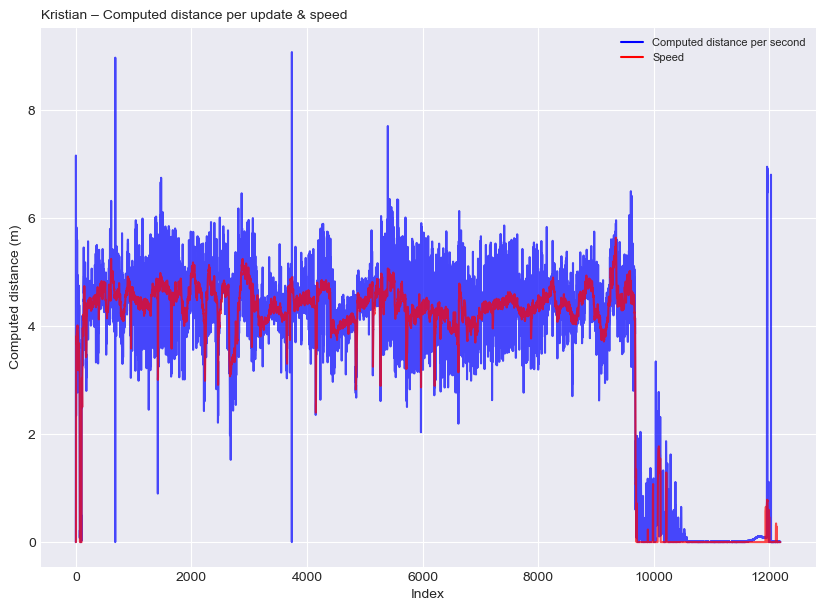



- Confirmed, very noisy in comparison!
- Also notice that Gustav's speed signal seems to have been smoothed more than Kristian's


In [10]:
# visualize this
# check the content of the calculated distance per update for both by plotting it over time 
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    ax.plot(iden_dat.distance_raw,
            color = 'blue',
            alpha = 0.7)
    ax.plot(blummenfelt_dat.distance_raw,
            color = 'red',
            alpha = 0.7)
    ax.set_title("Computed distance per GPS data point",
                fontsize = 10,
                loc = 'left')
    ax.legend(handles = [lines.Line2D([], [], color = 'blue'),
                    lines.Line2D([], [], color = 'red')],
         labels = ['Gustav', 
                   'Kristian'],
         fontsize = 8)
    ax.set_xlabel('Index')
    ax.set_ylabel('Computed distance (m)')
    plt.show()
    
print(
    "\n\n- Wow! Very noisy data..."
    "\n\n- This is basically a representation of the speed (it is in m/s because the index is reporting at 1 Hz)"
    "\n\n...so let's compare it to the speed\n"
)

# check the the calculated distance compared to speed by plotting it over time 
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    ax.plot(iden_dat.distance_raw,
            color = 'blue',
            alpha = 0.7)
    ax.plot(iden_dat.speed,
            color = 'red',
            alpha = 0.7)
    ax.set_title("Gustav – Computed distance per update & speed",
                fontsize = 10,
                loc = 'left')
    ax.legend(handles = [lines.Line2D([], [], color = 'blue'),
                         lines.Line2D([], [], color = 'red')],
              labels = ['Computed distance per second',
                        'Speed'],
              fontsize = 8)
    ax.set_xlabel('Index')
    ax.set_ylabel('Computed distance (m)')
    
    plt.show()
    
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    ax.plot(blummenfelt_dat.distance_raw,
            color = 'blue',
            alpha = 0.7)
    ax.plot(blummenfelt_dat.speed,
            color = 'red',
            alpha = 0.7)
    ax.set_title("Kristian – Computed distance per update & speed",
                fontsize = 10,
                loc = 'left')
    ax.legend(handles = [lines.Line2D([], [], color = 'blue'),
                         lines.Line2D([], [], color = 'red')],
              labels = ['Computed distance per second',
                        'Speed'],
              fontsize = 8)
    ax.set_xlabel('Index')
    ax.set_ylabel('Computed distance (m)')
    plt.show()
    
print(
    "\n\n- Confirmed, very noisy in comparison!"
    "\n- Also notice that Gustav's speed signal seems to have been smoothed more than Kristian's"
)


#### Compute Distance (more informed)

Three things jump out immediately from the initial attempt at computing distance:
1) The data needs to be cropped
2) Some of the GPS data points seem to be duplicated then over corrected in the next point (distance goes 0 -> 2x previous)
3) The data needs to be filtered – signal is very noisy. 
    * Usually GPS data has already been Kalman filtered on board the processor before being sent to any device so we will skip this step for now.
    * Applying a lowpass filter to the distance could be useful though.

Next code blocks attempt to remedy these issues

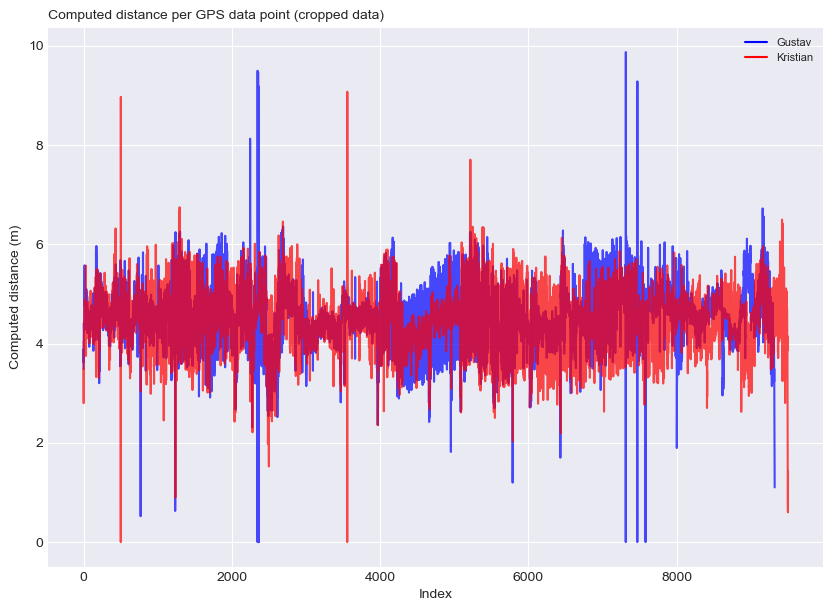

In [11]:
# Step 1: Crop the dataframes

# define variables
marker_columns = ['latitude', 'longitude', 'distance_travelled_raw'] # columns to use for markers
distance_start = 250 # searches below this distance for start over speed threshold 
distance_end = 41000 # searches above this distance for end under speed threshold
speed_threshold = 2 # how fast should an athlete be travelling to determine start and end of race

# extract markers from where cropping should take place
markers = krf.start_end_markers(iden_dat, marker_columns, distance_start, distance_end, speed_threshold)

# crop based on the marker location
iden_dat = krf.crop_by_markers(iden_dat, markers, marker_columns[2])
blummenfelt_dat = krf.crop_by_markers(blummenfelt_dat, markers, marker_columns[2])

# add time from zero column
iden_dat['time_sec'] = iden_dat.timestamp_unix - iden_dat.timestamp_unix.values[0]
blummenfelt_dat['time_sec'] = blummenfelt_dat.timestamp_unix - blummenfelt_dat.timestamp_unix.values[0]

# check what this did
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    ax.plot(iden_dat.distance_raw,
            color = 'blue',
            alpha = 0.7)
    ax.plot(blummenfelt_dat.distance_raw,
            color = 'red',
            alpha = 0.7)
    ax.set_title("Computed distance per GPS data point (cropped data)",
                fontsize = 10,
                loc = 'left')
    ax.legend(handles = [lines.Line2D([], [], color = 'blue'),
                    lines.Line2D([], [], color = 'red')],
         labels = ['Gustav', 
                   'Kristian'],
         fontsize = 8)
    ax.set_xlabel('Index')
    ax.set_ylabel('Computed distance (m)')
    plt.show()

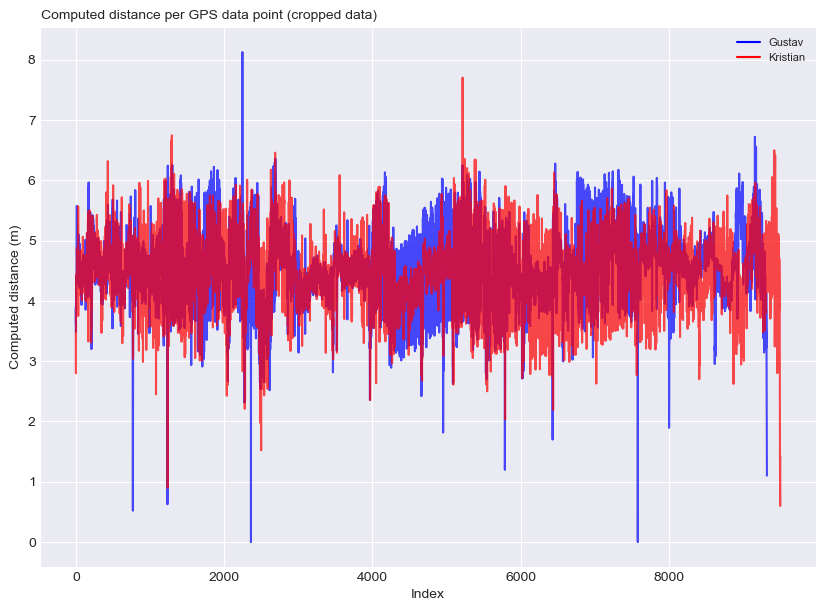

In [12]:
# Step 2: interpolate for duplicated position

iden_dat = krf.smooth_repeat_gps(iden_dat)
blummenfelt_dat = krf.smooth_repeat_gps(blummenfelt_dat)

with plt.style.context(style = 'seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    ax.plot(iden_dat.distance_raw,
            color = 'blue',
            alpha = 0.7)
    ax.plot(blummenfelt_dat.distance_raw,
            color = 'red',
            alpha = 0.7)
    ax.set_title("Computed distance per GPS data point (cropped data)",
                fontsize = 10,
                loc = 'left')
    ax.legend(handles = [lines.Line2D([], [], color = 'blue'),
                    lines.Line2D([], [], color = 'red')],
         labels = ['Gustav', 
                   'Kristian'],
         fontsize = 8)
    ax.set_xlabel('Index')
    ax.set_ylabel('Computed distance (m)')
    plt.show()

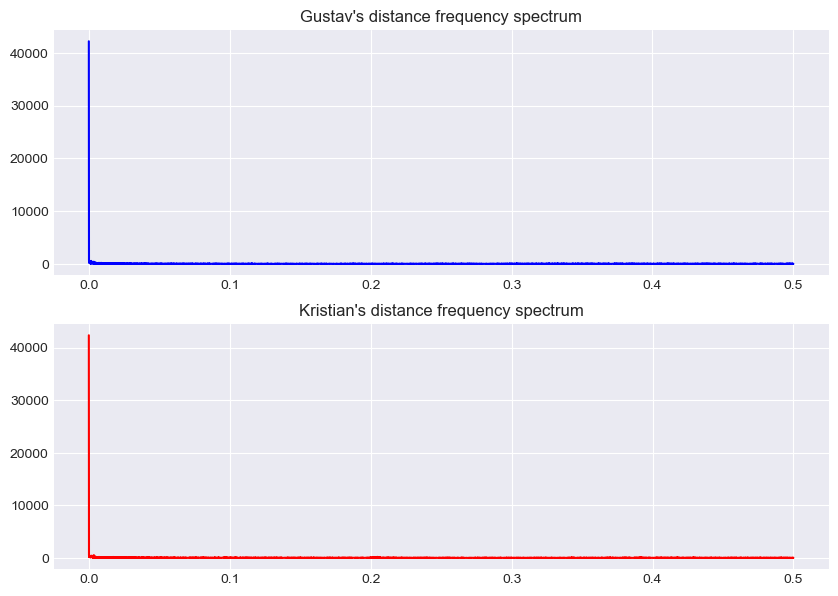

- The above representation is not very useful other than to show there is a large concetration of low frequency data.

- Repeat plot by removing first frequency to change plot limits:



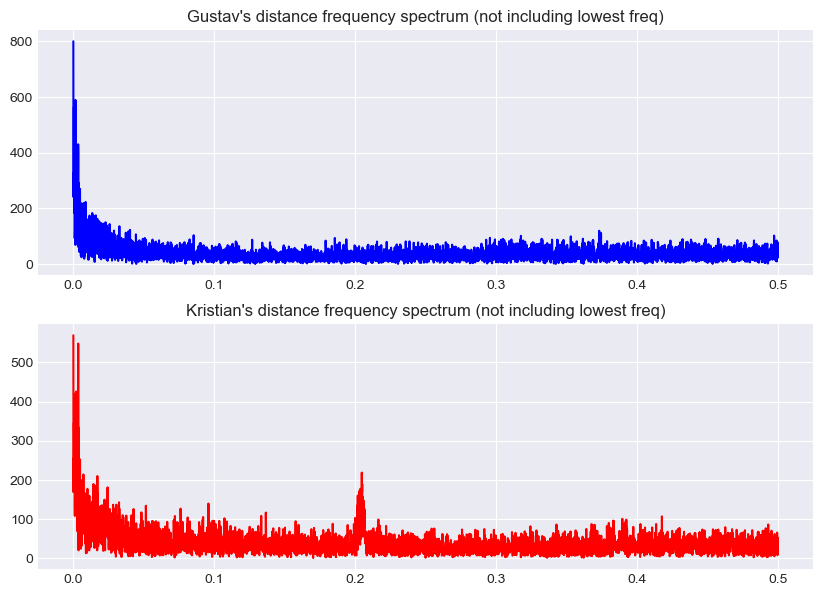

- Much clearer representaion, lowpass should be somewhere around 0.02-0.03; keep in mind Nyquist frequency is 0.5


In [13]:
# Step 3: Filter the computed distance

# i) Obtain frequency domain and appropriate lowpass frequency

# get the frequency domain using a fast fourier transformation
iden_xf, iden_yf = krf.distance_fft(iden_dat)
blummenfelt_xf, blummenfelt_yf = krf.distance_fft(blummenfelt_dat)

# plot to inspect the spectrum
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, axes = plt.subplots(2,1, figsize = (10,7))
    axes[0].plot(iden_yf,
                 np.abs(iden_xf),
                 color = 'blue')
    axes[0].set_title("Gustav's distance frequency spectrum")
    axes[1].plot(blummenfelt_yf,
                 np.abs(blummenfelt_xf),
                 color = 'red')
    axes[1].set_title("Kristian's distance frequency spectrum")
    plt.show()

print(
    "- The above representation is not very useful other than to show there is a large concetration of low frequency data."
    "\n\n- Repeat plot by removing first frequency to change plot limits:\n"
)
    
# repeat with first frequency removed
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, axes = plt.subplots(2,1, figsize = (10,7))
    axes[0].plot(iden_yf[1:],
                 np.abs(iden_xf[1:]),
                 color = 'blue')
    axes[0].set_title("Gustav's distance frequency spectrum (not including lowest freq)")
    axes[1].plot(blummenfelt_yf[1:],
                 np.abs(blummenfelt_xf[1:]),
                 color = 'red')
    axes[1].set_title("Kristian's distance frequency spectrum (not including lowest freq)")
    plt.show()
    
print(
    "- Much clearer representaion, lowpass should be somewhere around 0.02-0.03; keep in mind Nyquist frequency is 0.5"
)



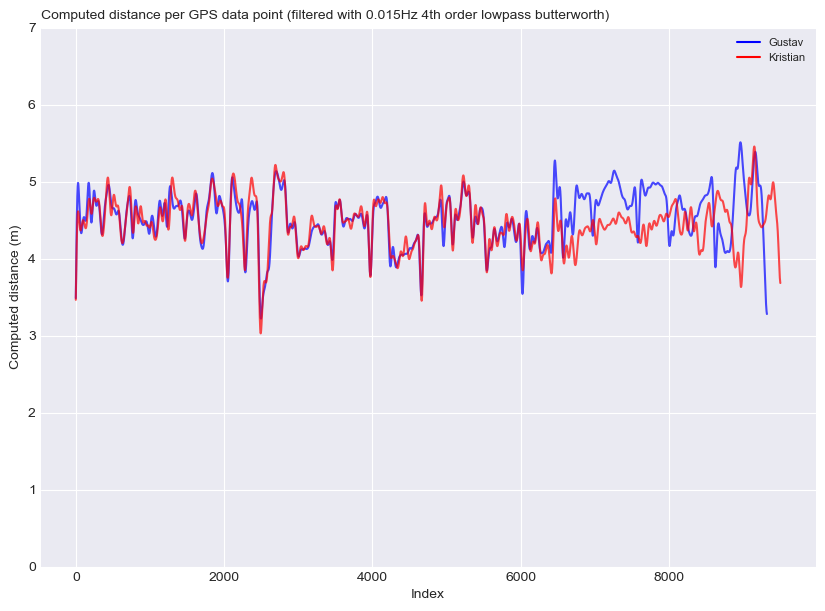

In [14]:
#ii) use a 4th order lowpass butterworth filter to smooth the computed distance value

# found through experimentation that 0.015 was appropriate value to retain structure & minimize noise
iden_dat['distance_filt'] = krf.butterworth_lowpass_filtfilt(iden_dat,
                                                             order = 4,
                                                             hz =  0.015)
blummenfelt_dat['distance_filt'] = krf.butterworth_lowpass_filtfilt(blummenfelt_dat,
                                                                    order = 4,
                                                                    hz = 0.015)

# plot to check 
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    ax.plot(iden_dat.distance_filt,
            color = 'blue',
            alpha = 0.7) 
    ax.plot(blummenfelt_dat.distance_filt,
            color = 'red',
            alpha = 0.7)
    ax.set_title("Computed distance per GPS data point (filtered with 0.015Hz 4th order lowpass butterworth)",
                fontsize = 10,
                loc = 'left')
    ax.legend(handles = [lines.Line2D([], [], color = 'blue'),
                    lines.Line2D([], [], color = 'red')],
         labels = ['Gustav', 
                   'Kristian'],
         fontsize = 8)
    ax.set_xlabel('Index')
    ax.set_ylabel('Computed distance (m)')
    ax.set_ylim(0,7)
    plt.show()

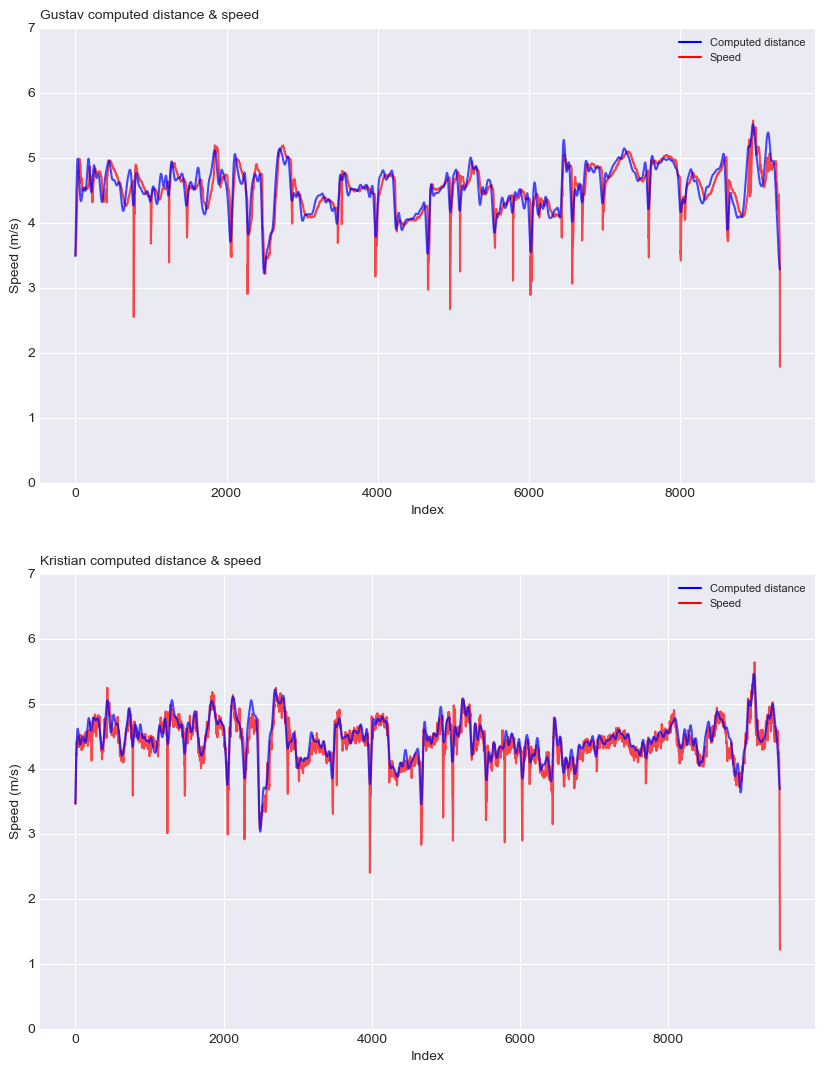


- Filter response on computed distance removes rapid drops in speed; some of which could be real drops
- Note the constant up-down nature of the speed profile; due to the varying elevation profile of the race
- Gustav's speed signal is much more smoothed than Kristian's
- Gustav's speed signal has had a rolling average applied to it (30s); meaning values are shifted slightly
- Overall, lowpass filter has reduced noise to a level similar to Gustav's data and has reduced noise for Kristian


Gustav travelled: 
42212m, 42211m & 42180m based on the raw distance, filtered distance and speed measure, respectively


Kristian travelled: 
42338m, 42347m & 41758m based on the raw distance, filtered distance and speed measure, respectively


- So we do have slight differences between methods and the computed distance measures based on GPS signal
  yield more total distance than the speed measure.

- Also, Kristian's dataset has more distance travelled than Gustav's when the total distance is bas

In [15]:
# lets compare this computed distance measure now with the speed value
# the speed is usually some combination of a filtered distance measure and speed sensor (or accelerometer) input

# its in m/s already so same units and directly comparable
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, ax = plt.subplots(2,1, figsize = (10,13))
    ax[0].plot(iden_dat.speed,
               color = 'red',
               alpha = 0.7) 
    ax[0].plot(iden_dat.distance_filt,
               color = 'blue',
               alpha = 0.7)     
    ax[1].plot(blummenfelt_dat.speed,
               color = 'red',
               alpha = 0.7) 
    ax[1].plot(blummenfelt_dat.distance_filt,
               color = 'blue',
               alpha = 0.7)
    
    ax[0].set_title("Gustav computed distance & speed",
                    fontsize = 10,
                    loc = 'left')
    ax[1].set_title("Kristian computed distance & speed",
                    fontsize = 10,
                    loc = 'left')
    ax[0].legend(handles = [lines.Line2D([], [], color = 'blue'),
                            lines.Line2D([], [], color = 'red')],
                 labels = ['Computed distance', 
                           'Speed'],
                 fontsize = 8)
    ax[1].legend(handles = [lines.Line2D([], [], color = 'blue'),
                            lines.Line2D([], [], color = 'red')],
                 labels = ['Computed distance', 
                           'Speed'],
                 fontsize = 8)
    
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Speed (m/s)')
    ax[0].set_ylim(0,7)
    ax[1].set_xlabel('Index')
    ax[1].set_ylabel('Speed (m/s)')
    ax[1].set_ylim(0,7)
    plt.show()
    
print(
    "\n- Filter response on computed distance removes rapid drops in speed; some of which could be real drops"
    "\n- Note the constant up-down nature of the speed profile; due to the varying elevation profile of the race"
    "\n- Gustav's speed signal is much more smoothed than Kristian's"
    "\n- Gustav's speed signal has had a rolling average applied to it (30s); meaning values are shifted slightly"
    "\n- Overall, lowpass filter has reduced noise to a level similar to Gustav's data and has reduced noise for Kristian"
)

# compare total distance travelled now with raw distance, filtered distance and speed
# set the initial speed to 0 for all measures (even though this probably wasn't the real start of the race)
iden_dat.loc[0, ['distance_raw', 'distance_filt', 'speed']] = 0
blummenfelt_dat.loc[0, ['distance_raw', 'distance_filt', 'speed']] = 0

# cumulative distance travelled
iden_dat['distance_travelled_raw'] = iden_dat.loc[:,'distance_raw'].cumsum()
iden_dat['distance_travelled_filt'] = iden_dat.loc[:,'distance_filt'].cumsum()
iden_dat['distance_travelled_speed'] = iden_dat.loc[:,'speed'].cumsum()
# same for kristian
blummenfelt_dat['distance_travelled_raw'] = blummenfelt_dat.loc[:,'distance_raw'].cumsum()
blummenfelt_dat['distance_travelled_filt'] = blummenfelt_dat.loc[:,'distance_filt'].cumsum()
blummenfelt_dat['distance_travelled_speed'] = blummenfelt_dat.loc[:,'speed'].cumsum()

print(
    "\n\n"
    f"Gustav travelled: \n{int(iden_dat.distance_travelled_raw.max())}m,"
    f" {int(iden_dat.distance_travelled_filt.max())}m &"
    f" {int(iden_dat.distance_travelled_speed.max())}m"
    " based on the raw distance, filtered distance and speed measure, respectively"
)

print(
    "\n\n"
    f"Kristian travelled: \n{int(blummenfelt_dat.distance_travelled_raw.max())}m,"
    f" {int(blummenfelt_dat.distance_travelled_filt.max())}m &"
    f" {int(blummenfelt_dat.distance_travelled_speed.max())}m"
    " based on the raw distance, filtered distance and speed measure, respectively"
)

print(
    "\n\n- So we do have slight differences between methods and the computed distance measures based on GPS signal"
    "\n  yield more total distance than the speed measure."
    "\n\n- Also, Kristian's dataset has more distance travelled than Gustav's when the total distance is based on"
    "\n  the GPS signal but less when using speed to calculate total distance which highlights the difference in computation"
)


#### Compare based on distance

Now that we have a distance travelled measure we can try to compare efforts based on distance by interpolating data to known distances. 

The first thing to compare will be the time gap between the two athletes. This should be easy to validate because the athletes ran the race together for a large chunk and then Gustav ran away from Kristian and beat him by a little under 3 minutes.

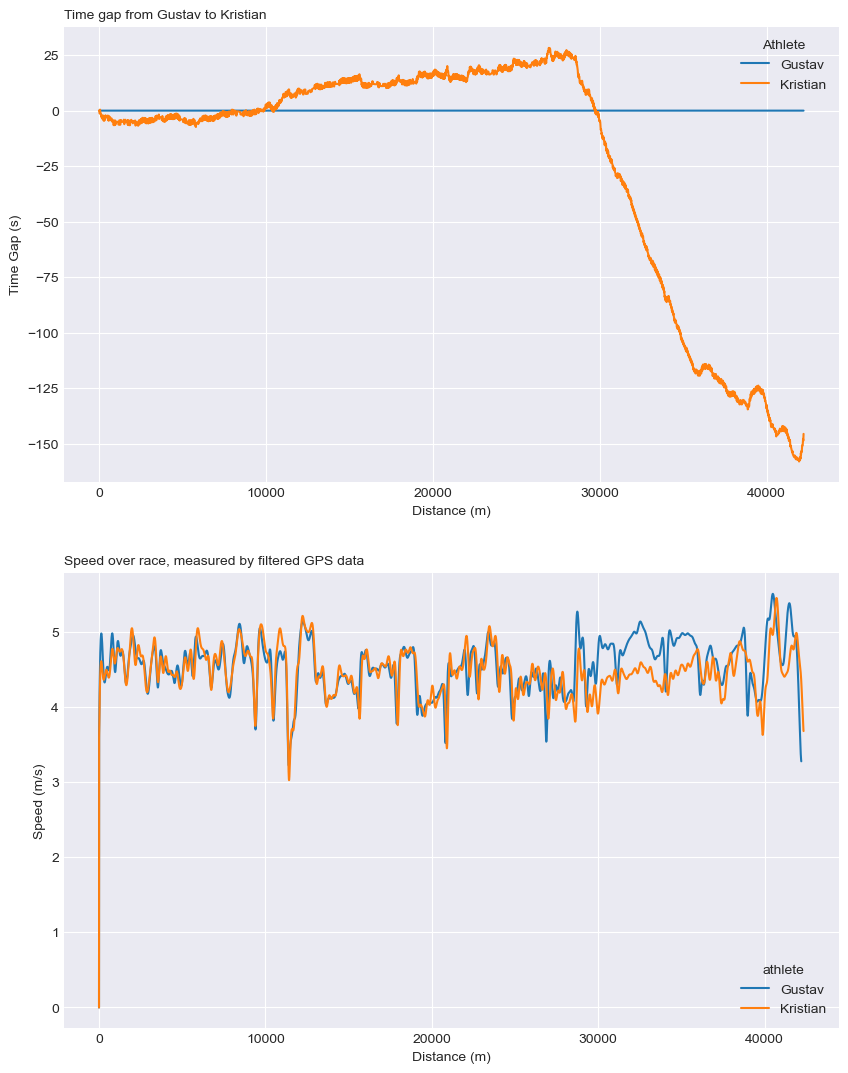


- Interestingly, we see some drift in the time gap that did not exist in real life
- Final difference in time is only 150s, but should be close to 180s
- Difference from point where Kristian starts to lose time and finish would be ~180s
- See that the speed profiles become decoupled later in the race, indicating maybe the distance travelled is not accurate across athletes
- Need to check the difference in their position based on their distance travelled


In [16]:
# add name identifier because we are going to combined into one frame
iden_dat['athlete'] = 'Gustav'
blummenfelt_dat['athlete'] = 'Kristian'

# concat the dataframes together
combined_dat = pd.concat([iden_dat,
                          blummenfelt_dat],
                         axis = 0,
                         sort = False).reset_index(drop = True)

# set some variables for next step
compare_against = 'Gustav'
interp_distance = 15
distance_column = 'distance_travelled_filt'
speed_column = 'distance_filt'

# create a new frame that has a time gap to a specific athlete
delta_time_dat = krf.compare_time(combined_dat, 
                                  compare_against,
                                  interp_distance,
                                  distance_column,
                                  speed_column)

# plot the data
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, ax = plt.subplots(2,1, figsize = (10,13))
    sns.lineplot(data = delta_time_dat, 
                 x = 'Distance', 
                 y = 'Time_Gap', 
                 hue = 'Athlete', 
                 ax = ax[0])
    ax[0].set_title("Time gap from Gustav to Kristian",
                    loc = 'left',
                    fontsize = 10)
    ax[0].set_ylabel("Time Gap (s)")
    ax[0].set_xlabel("Distance (m)")
    
    sns.lineplot(data = combined_dat, 
                 x = 'distance_travelled_filt', 
                 y = 'distance_filt', 
                 hue = 'athlete', 
                 ax=ax[1])
    ax[1].set_title("Speed over race, measured by filtered GPS data",
                   loc = 'left',
                   fontsize = 10)
    ax[1].set_ylabel("Speed (m/s)")
    ax[1].set_xlabel("Distance (m)")
    
    plt.show()
    
print(
    "\n- Interestingly, we see some drift in the time gap that did not exist in real life"
    "\n- Final difference in time is only 150s, but should be close to 180s"
    "\n- Difference from point where Kristian starts to lose time and finish would be ~180s"
    "\n- See that the speed profiles become decoupled later in the race, indicating maybe the distance travelled is not accurate across athletes"
    "\n- Need to check the difference in their position based on their distance travelled"
)
    

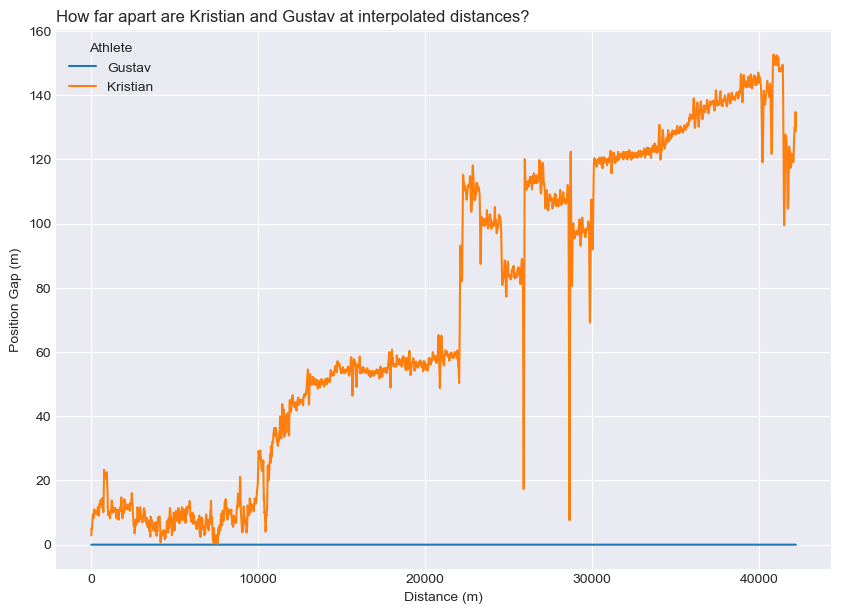

In [17]:
# set some variables for next step
compare_against = 'Gustav'
interp_distance = 15
distance_column = 'distance_travelled_filt'
speed_column = 'distance_filt'

# create a new frame that has a position gap to a specific athlete
# this calculates the distance between their GPS data based on the distance travelled
delta_position_dat = krf.compare_position(combined_dat,
                                          compare_against,
                                          interp_distance,
                                          distance_column,
                                          speed_column)

# plot the data
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    sns.lineplot(data = delta_position_dat, x = 'Distance', y = 'Distance_Gap', hue = 'Athlete', ax = ax)
    ax.set_title("How far apart are Kristian and Gustav at interpolated distances?",
                   loc = 'left',
                   fontsize = 12)
    ax.set_ylabel("Position Gap (m)")
    ax.set_xlabel("Distance (m)")
    
    plt.show()


#### Back to the drawing board

We know that the time gap should be at or near zero until Gustav pulled away from Kristian just before 30km mark in the run; however, the time gaps observed based on each athlete's distance travelled did not display this. 

We see why this may have occurred from the graph showing the position gap over distance. The interpretation from this graph is that as the race progresses, the computed distance travelled by the athletes does not accurately represent how far they are along in the race. Indeed, Kristian travels further than Gustav for the same start/finish locations and the distance between their GPS location increases as the race progresses when interpolating using their computed distance travelled. 

I mentioned before that typically a Kalman filter is applied to GPS data and it is possible that this was not the case for one or both of these datasets and this has led to excess distance travelled. But without knowing if one was used, it would be hard to (re)apply a smoothing algorithm to their coordinates. Even if this method was employed I am skeptical it would completely rectify the issues presented given the magnitude of the disparity.

A solution though, would be to use one of the athlete's data as a course map. For this to work, we would have to assume the distance to be correct for one of the athletes and apply a distance measure to the other athlete according to the proximity of the their GPS data to the reference map. 

This approximates to my preferred method of having a course gpx file, but instead uses data from one of the competiting athletes as a reference. It is also possible to do this when you have a number of athlete's datasets – you can produce an average distance for a given position and use that as the reference. 

Let's give this a try using Gustav's data as the reference as his distance travelled was close to the marathon distance.

In [18]:
# map the distance from Gustav to Kristian based on the GPS position
# slow process - takes apprx 70-80 secs; could be sped up considerably but not the point of this workflow

# create column 
iden_dat['distance_travelled_mapped'] = iden_dat.distance_travelled_filt.copy()
# function finds distance travelled at closest GPS point of Gustav for each GPS point of Kristian
blummenfelt_dat['distance_travelled_mapped'] = krf.map_distance_travelled(iden_dat, blummenfelt_dat)

# same process as before with time gap
# concat df's
combined_dat = pd.concat([iden_dat,
                          blummenfelt_dat],
                         axis = 0,
                         sort = False).reset_index(drop = True)

# set some variables for next step
compare_against = 'Gustav'
interp_distance = 15
distance_column = 'distance_travelled_mapped'
speed_column = 'distance_filt'

# create delta time calculation from one athlete to another
delta_time_dat = krf.compare_time(combined_dat, 
                                  compare_against,
                                  interp_distance,
                                  distance_column,
                                  speed_column)


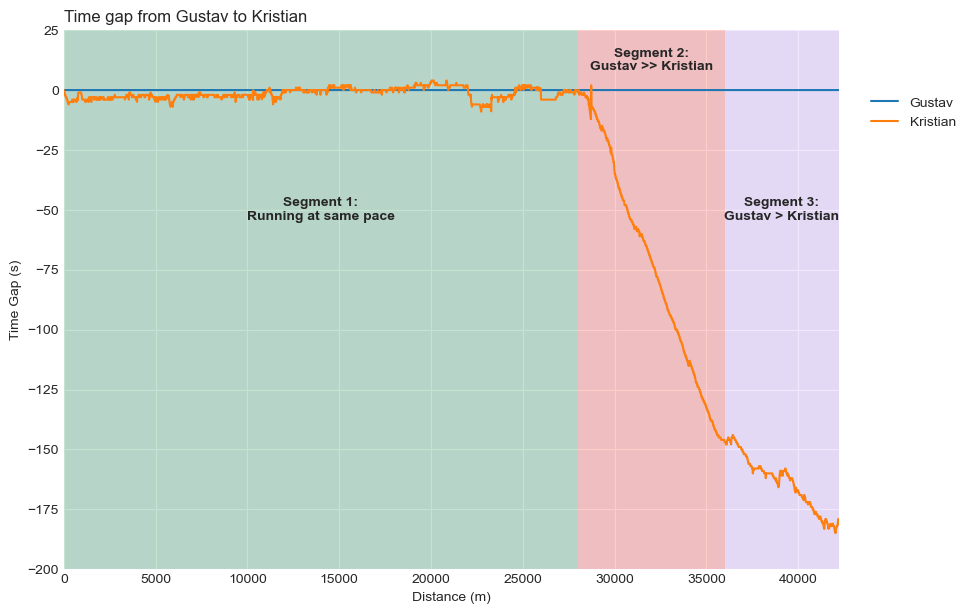


- Much better, this worked!
- Three clear regions of interest to investigate: 
      i) same speed km's 0-28, ii) rapid time gain km's 28-36, iii) less rapid time gain km's 36-42


In [23]:
# plot this data

# create patches to plot areas of interest
patch1 = patches.Rectangle((0,-200), 
                           width = 28000, height = 250,
                           alpha = 0.3,
                          facecolor = "xkcd:greenish")
patch2 = patches.Rectangle((28000,-200), 
                           width = 8000, height = 250,
                           alpha = 0.3,
                          facecolor = "xkcd:coral")
patch3 = patches.Rectangle((36000,-200), 
                           width = 6200, height = 250,
                           alpha = 0.3,
                          facecolor = "xkcd:light violet")

# plot the data
with plt.style.context(style = 'seaborn-darkgrid'):
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    sns.lineplot(data = delta_time_dat, x = 'Distance', y = 'Time_Gap', hue = 'Athlete', ax = ax)
    ax.set_title("Time gap from Gustav to Kristian",
                   loc = 'left',
                   fontsize = 12)
    ax.set_ylabel("Time Gap (s)",
                    fontsize = 10)
    ax.set_xlabel("Distance (m)",
                    fontsize = 10)
    
    handles, labels = ax.get_legend_handles_labels()
    
    ax.legend(handles, labels,
              loc = 'upper left',
             bbox_to_anchor = [1.025,0.9],
             fancybox = True)
    ax.add_patch(patch1)
    ax.annotate(text = "Segment 1:\nRunning at same pace",
               xy = (14000,-50),
               ha = 'center',
               va = 'center',
               fontsize = 10,
               fontweight = 'bold')
    ax.add_patch(patch2)
    ax.annotate(text = "Segment 2:\nGustav >> Kristian",
               xy = (32000,12.5),
               ha = 'center',
               va = 'center',
               fontsize = 10,
               fontweight = 'bold')
    ax.add_patch(patch3)
    ax.annotate(text = "Segment 3:\nGustav > Kristian",
               xy = (39100,-50),
               ha = 'center',
               va = 'center',
               fontsize = 10,
               fontweight = 'bold')
    
    ax.set_ylim(-200, 25)
    ax.set_xlim(0,delta_time_dat.Distance.max())
    
    plt.show() 

print(
    "\n- Much better, this worked!"
    "\n- Three clear regions of interest to investigate: "
    "\n      i) same speed km's 0-28, ii) rapid time gain km's 28-36, iii) less rapid time gain km's 36-42"
)

#### Now let's analyze these segments

Given these three clear distinct segments in the time gap graph, let's assess how the athletes performed in each of the segments to give an idea of how the gap in time occurred. 


In [20]:
# set variables
# the distances for segment markers
marker_dists = [iden_dat.distance_travelled_mapped.values[0],
                28000, 
                36000,
                iden_dat.distance_travelled_mapped.values[-1]]
# columns to use when getting markers
marker_cols = ['latitude', 
               'longitude', 
               'distance_travelled_mapped']
# preset sensor columns to average by segment
columns_to_avg = ['speed', 'cadence', 'stride_length', 'heartrate']

# get markers of interest
new_markers = krf.get_markers_from_distances(reference_df = iden_dat,
                                             distances = marker_dists,
                                             columns = marker_cols)

# create segments from markers 
iden_dat = krf.crop_by_markers(df = iden_dat, 
                               markers = new_markers, 
                               distance_measure = marker_cols[2])

# create dataframes of data grouped over segment
segment_dat_iden = krf.avg_sensors_by_segment(df = iden_dat,
                                              sensors = columns_to_avg)

# add a identifier to % change
segment_dat_iden['segment_change']['athlete'] = 'Gustav'

# output the frame to see data
print(
    "\nGustav sensor averages in real magnitudes for each segment"
)
display(segment_dat_iden['segment_means'])

# do the same thing for kristian
blummenfelt_dat = krf.crop_by_markers(blummenfelt_dat, new_markers, marker_cols[2])

# create dataframes of data grouped over segment
segment_dat_blummenfelt = krf.avg_sensors_by_segment(df = blummenfelt_dat,
                                              sensors = columns_to_avg)

# add a identifier to % change
segment_dat_blummenfelt['segment_change']['athlete'] = 'Kristian'

# output the frame to see data
print(
    "\nKristian sensor averages in real magnitudes for each segment"
)
display(segment_dat_blummenfelt['segment_means'])



Gustav sensor averages in real magnitudes for each segment


,speed,cadence,stride_length,heartrate
segment,,,,
1,4.449850,85.810145,1.557096,161.044363
2,4.730145,88.104265,1.614807,170.618483
3,4.611150,88.362287,1.571005,174.959911



Kristian sensor averages in real magnitudes for each segment


,speed,cadence,stride_length,heartrate
segment,,,,
1,4.408207,86.275199,1.555574,144.570270
2,4.307890,86.221374,1.519150,143.893675
3,4.439196,88.235337,1.535646,149.881970


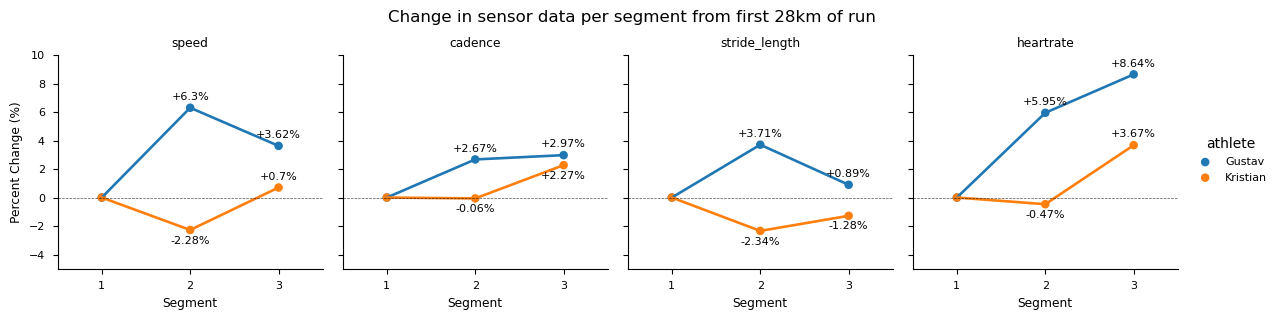


- Gustav increased his speed substantially in segment 2 (6.3%). This was accomplished by increasing both
  his cadence (2.67%) and stride length (3.71%). Accompanying this increase in pace was an elevated
  heart rate (5.95%). At this point in the race, Kristian was not able to match the increase in pace
  and actually decreased his speed by a small amount relatively (-2.28%), while maintaining his cadence but
  reducing his stride length (-2.34%). Judging from his heart rate, he maintained a consistent aerobic
  expenditure from segment 1 to 2.

- In segment 3, Gustav reduced his speed from segment 2 but maintained a speed higher than segment 1 (3.62%).
  His cadence remained higher than segment 1 and was similar to segment 2, but his stride length dropped to
  be slightly above segment 1 levels (0.89%). Gustav's heart rate continued to increase in segment 3 (8.64%).
  This could be have been due to the intense effort put forth in segment 2 and lagging reductions in
  efficiency from

In [25]:
# plot this so it is more easily comparable

# concat those frames together
grouped_change = pd.concat([segment_dat_iden['segment_change'], segment_dat_blummenfelt['segment_change']]).reset_index(drop = True)

# plot this in a facet grid 
with plt.style.context(style = 'seaborn-paper'):
    # create the grid
    g = sns.FacetGrid(data = grouped_change, 
                      col = 'sensor', 
                      hue = 'athlete',
                      height = 3,
                      legend_out = True)
    # map pointplot data to grid
    g.map(sns.pointplot, 'segment', 'percent_change', order = [1,2,3], scale = 0.75)
    #set titles
    g.fig.subplots_adjust(top = 0.9)
    g.fig.suptitle('Change in sensor data per segment from first 28km of run',
                  y = 1.05)
    g.set_ylabels('Percent Change (%)')
    g.set_xlabels("Segment")
    g.set_titles(col_template="{col_name}")
    g.add_legend()
    # loop through the axes
    for key, ax in g.axes_dict.items():
        # set ylimits for all plots
        ax.set_ylim(-5,10)
        # add a 0 line reference
        ax.axhline(color = 'k', 
                   linestyle = '--', 
                   alpha = 0.7,
                  linewidth = 0.5)
        # finding which axis we are on
        indexer = (grouped_change.loc[:,'sensor'] == key)
        points = grouped_change.loc[indexer, :]
        # loop through all the points in df
        for segment, percent_change in zip(points.segment, points.percent_change):
            # if more than 0, put text above the data point
            if percent_change > 0:
                text = '+' + str(round(percent_change, 2))  + "%"
                # manual adjust for overlay of close points
                if key == 'cadence' and percent_change < 2.9 and segment == 3:
                    xy = (segment - 1, percent_change - 0.75)
                else: 
                    xy = (segment - 1, percent_change + 0.75)
                # annotate the data point with text
                ax.annotate(text, xy,
                           ha = 'center',
                           va = 'center',
                           fontsize = 8)
            # if lower than zero, put the text blow the data point
            elif percent_change < 0:
                text = str(round(percent_change, 2)) + "%"
                xy = (segment - 1, percent_change - 0.75) 
                ax.annotate(text, xy,
                           ha = 'center',
                           va = 'center',
                           fontsize = 8)
                
    plt.show() 

print(
    "\n- Gustav increased his speed substantially in segment 2 (6.3%). This was accomplished by increasing both"
    "\n  his cadence (2.67%) and stride length (3.71%). Accompanying this increase in pace was an elevated"
    "\n  heart rate (5.95%). At this point in the race, Kristian was not able to match the increase in pace"
    "\n  and actually decreased his speed by a small amount relatively (-2.28%), while maintaining his cadence but"
    "\n  reducing his stride length (-2.34%). Judging from his heart rate, he maintained a consistent aerobic"
    "\n  expenditure from segment 1 to 2.\n"
    "\n- In segment 3, Gustav reduced his speed from segment 2 but maintained a speed higher than segment 1 (3.62%)."
    "\n  His cadence remained higher than segment 1 and was similar to segment 2, but his stride length dropped to"
    "\n  be slightly above segment 1 levels (0.89%). Gustav's heart rate continued to increase in segment 3 (8.64%)."
    "\n  This could be have been due to the intense effort put forth in segment 2 and lagging reductions in"
    "\n  efficiency from metabolite accumulation, neuromuscular fatigue and temperature increases. For the same"
    "\n  segment, Kristian was able to bump his speed back up slightly – above levels from segment 1 by 0.7%."
    "\n  This increase in speed corresponded with an increase in cadence from segment 1 and 2 (2.27% and 2.21%,"
    "\n  respectively). In addition, his stride length increased from segment 2, but remained below segment 1"
    "\n  values (-1.28%). Lastly, Kristian's heart rate rose only slightly above his segment 1 and 2 values;"
    "\n  a clear sign that he was measuring his effort in the previous segments so he didn't blow up before the finish"
)

#### Last thing: average pace (min/km) over different distances

Now that we have accurate distances across athletes we can also accurately measure their average running pace over different distances throughout the race. Averaging pace over distances can make comparing speed an easier task than simply interpreting the raw speed measure output from the Garmin device as that often has a complex structure.

Below I will compare the two athlete's pace over 5km stretches. This could be modified to include any distance, but for this distance of a race 5km seems like it would create an appropriate amount of information to compare against.  

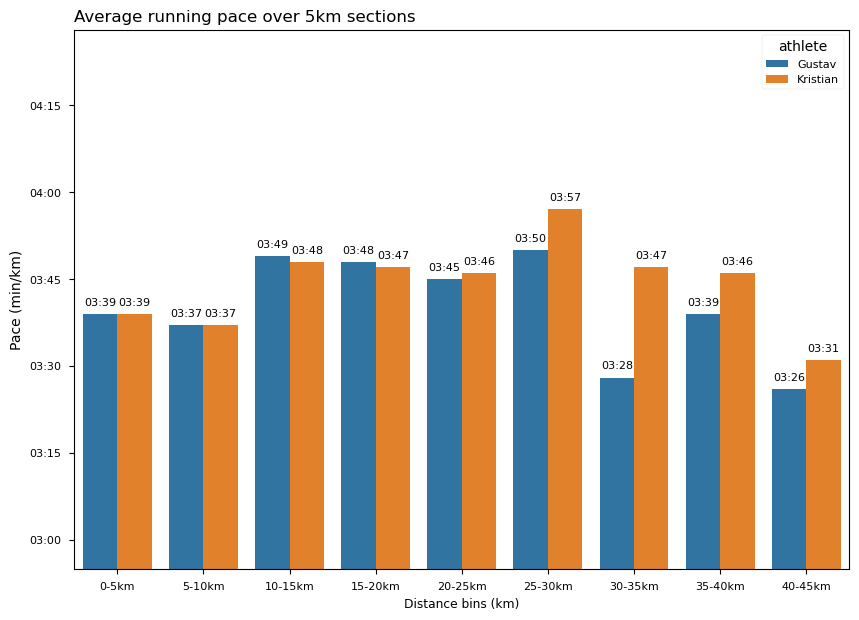


- First 10km was done at 3:38 min/km
- Next 15km were done at ~3:46 min/km
- Deviation in pace starts at around 25-30km mark; Kristian slowed to 3:57, Gustav roughly the same as previous 15km
- Gustav really picked up the pace to 3:28; Kristian back to 3:47
- Pace got closer over the final 7km, but Gustav still put ~45 seconds into Kirstian in this time


In [26]:
# set variables
distance_interval = 5000
distance_measure = 'distance_travelled_mapped'
round_digits = 0

# obtain average pace of the requested distance interval
iden_pace = krf.pace_average_over_distance(df = iden_dat,
                                            distance_interval = distance_interval,
                                            distance_measure = distance_measure,
                                            round_digits = round_digits)
# set name for easy use of seaborn
iden_pace['athlete'] = 'Gustav'

# same with kristian
blummenfelt_pace = krf.pace_average_over_distance(df = blummenfelt_dat,
                                                    distance_interval = distance_interval,
                                                    distance_measure = distance_measure,
                                                    round_digits = round_digits)
blummenfelt_pace['athlete'] = 'Kristian'

# concat frames together 
grouped_pace = pd.concat([iden_pace, blummenfelt_pace]).reset_index(drop = True)

# plot
with plt.style.context(style = 'seaborn-paper'):
    # create axis and figure
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    # plot data
    sns.barplot(data = grouped_pace,
                x = 'distance_bin',
                y = 'pace_s_km',
                hue = 'athlete',
                dodge = True)
    # set y lim based on range of sample
    pace_range = grouped_pace.pace_s_km.max() - grouped_pace.pace_s_km.min()
    ax.set_ylim(grouped_pace.pace_s_km.min() - pace_range, 
                grouped_pace.pace_s_km.max() + pace_range) 
    # convert y axis seconds to mins:seconds
    ax.yaxis.set_major_locator(ticker.MultipleLocator(15))
    ytick_labels = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(ticker.FixedLocator(ytick_labels))
    new_yticks_labels = [datetime.strftime(datetime.fromtimestamp(x), format = "%M:%S") for x in ytick_labels]
    ax.set_yticklabels(new_yticks_labels)
    # label axes and title
    ax.set_title("Average running pace over 5km sections",
                 loc = 'left',
                 size = 12)
    ax.set_ylabel("Pace (min/km)",
                  size = 10)
    ax.set_xlabel("Distance bins (km)")
    
    # add text to bars
    for rect in ax.patches:
        # set where the text will go
        x = rect.get_x()
        width = rect.get_width() / 2
        added_height = 2
        height = rect.get_height()
        # the text
        if round_digits > 0:
            text = datetime.strftime(datetime.fromtimestamp(height), format = "%M:%S.%f")[:(-6+round_digits)]
        else:
            text = datetime.strftime(datetime.fromtimestamp(height), format = "%M:%S")
        # add text
        ax.annotate(text = text, 
                    xy = (x + width, 
                        height + added_height),
                    ha = 'center',
                    va = 'center',
                    fontsize = 8)
        
    plt.show()
    
print(
    "\n- First 10km was done at 3:38 min/km"
    "\n- Next 15km were done at ~3:46 min/km"
    "\n- Deviation in pace starts at around 25-30km mark; Kristian slowed to 3:57, Gustav roughly the same as previous 15km"
    "\n- Gustav really picked up the pace to 3:28; Kristian back to 3:47"
    "\n- Pace got closer over the final 7km, but Gustav still put ~45 seconds into Kirstian in this time"
)
    
    